# RF Power Amplifier Envelope Distortion Modeling

Modeling the behavior of an RF power amplifier is not a simple task. 
In particular, modern RF power amplifiers exhibit significant nonlinear distortions that must be modeled in order to predict or correct for these distortions. 
However, not only the current, but also all previous inputs to a power amplifier device must be considered in order to predict the correct power amplifier outputs. 
In this example, we will explore different RNN structures to achieve this goal.

Note, this is a bit of a simplified example. Normally you would be operating complex-valued base-band 
signals but for the sake of simplicity we focus on just modeling the power envelope of the signal.
A bit of more background here: the RF Amplifier Operates an upconverted high-frequency signal. 
However, the majority of the distortion "just" affect the "envelope" of the RF signal, thus, for modeling it we can begin with just the magnitude of the converted base-band signals. 

We start, as always, by importing the necessary libraries. 

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
# this is how you import data from Matlab. 
# loadmat returns a dictionary
mat = loadmat("./Lab3_Data.mat") # assuming that the data is in the same folder...

x = mat['pa_input']
y = mat['pa_output']

The next few lines section plot the behavior that should be modeled.
The samples in x and y are a time-series, so their order corresponds to the time dimension. 
Observe the scattering/hysteresis around the instantaneous behaviour. This is the dynamic/memory effect of the power amplifier.

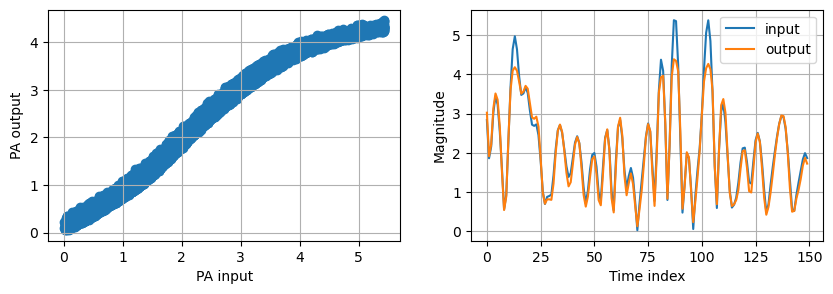

In [4]:
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.xlabel("PA input"), plt.ylabel("PA output"), plt.grid()
plt.subplot(1, 2, 2)
plt.plot(x[50:200], label="input")
plt.plot(y[50:200], label="output")
plt.xlabel("Time index"), plt.ylabel("Magnitude"), plt.grid(), plt.legend()
plt.show()

Let's use the first 60k samples in the dataset for training and the last 20k samples as validation data.
Don't forget to scale/standardize your data.
Additionally you will need to reshape the data, as explained in the next block. 

In [44]:
# TODO:
n_timesteps = 20
n_gru_units = 6
n_dense = 16

n_train = n_timesteps*int(60_000/(n_timesteps))
n_valid = n_timesteps*int(20_000/(n_timesteps))

x = x/np.max(x)
y = y/np.max(y)

x_train = np.transpose(np.reshape(x[0:n_train], (-1,1,n_timesteps)), (0,2,1))
y_train = np.transpose(np.reshape(y[0:n_train], (-1,1,n_timesteps)), (0,2,1))

x_valid = np.transpose(np.reshape(x[-n_valid:], (-1,1,n_timesteps)), (0,2,1))
y_valid = np.transpose(np.reshape(y[-n_valid:], (-1,1,n_timesteps)), (0,2,1))


Let's define an RNN sequence-to-sequence model with a GRU layer with `6 units`. (GRU=gated recurrent unit).

A seq-to-seq model means, that with every time step, the RNN output is returned. \
For that to happen, we need to specify `return_sequences=True` for the RNN layer.

The model should then look like:
Input layer -> GRU layer (6) -> hidden/fully-connected layer-> output layer

To model the PA amplitude, our model in principle takes one input feature and one output feature.\
However, training of RNNs requires to unroll the RNN structures in time, to be able to find proper gradients. \
The depth of the unrolling is often referred as "timesteps", I suggest trying these in the range between 10 and 50. \
While TF does the unrolling of the RNN automatically, we need to include the number of time-steps for unrolling in the first dimension of the shape argument of the input layer.

We also need to prepare the input and output training data accodingly, with data dims specified as [batch-dim, timesteps, features]. \
Thus, in the second dimension (timesteps), consecutive samples should be correctly following one another. 

Try to observe the performance with an additional metric 'log MSE' and check the convergence using the logarithic metric.

In [83]:
# TODO:
input_layer = K.Input(shape=(n_timesteps, 1))
gru_layer = K.layers.GRU(units=n_gru_units, return_sequences=True)(input_layer)
#gru_layer = K.layers.Dense(units=n_gru_units)(input_layer)
hidden_layer = K.layers.Dense(units=n_dense, activation=K.activations.relu)(gru_layer)
output_layer = K.layers.Dense(1)(hidden_layer)

RNN_model = K.Model(input_layer, output_layer)

In [84]:
# TODO:
RNN_model.compile( 
    optimizer=K.optimizers.Adam(learning_rate=0.001),
    loss=K.losses.MeanSquaredError(),
    metrics=K.metrics.MeanSquaredLogarithmicError())
hist = RNN_model.fit(x=x_train, y=y_train, epochs=100, validation_data=(x_valid, y_valid))

Epoch 1/100
94/94 [==============================] - 1s 6ms/step - loss: 0.0172 - mean_squared_logarithmic_error: 0.0082 - val_loss: 0.0011 - val_mean_squared_logarithmic_error: 5.5649e-04
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 6.5866e-04 - mean_squared_logarithmic_error: 3.4158e-04 - val_loss: 5.8113e-04 - val_mean_squared_logarithmic_error: 3.0921e-04
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 5.5797e-04 - mean_squared_logarithmic_error: 3.0183e-04 - val_loss: 5.7213e-04 - val_mean_squared_logarithmic_error: 3.0536e-04
Epoch 4/100
94/94 [==============================] - 0s 1ms/step - loss: 5.5125e-04 - mean_squared_logarithmic_error: 2.9893e-04 - val_loss: 5.6390e-04 - val_mean_squared_logarithmic_error: 3.0211e-04
Epoch 5/100
94/94 [==============================] - 0s 1ms/step - loss: 5.4241e-04 - mean_squared_logarithmic_error: 2.9424e-04 - val_loss: 5.5511e-04 - val_mean_squared_logarithmic_error: 2.9548e-04
Epoch 6

Use the model's predict method to get an output. The validation datay you provide to the predict method has to follow the same arrangement as the training data.\
Although RNNs benefit from longer training, you can reach a good converged performance with just 100 epochs. 

Plot the output to input amplitude for the power amplifier and the model and compare.

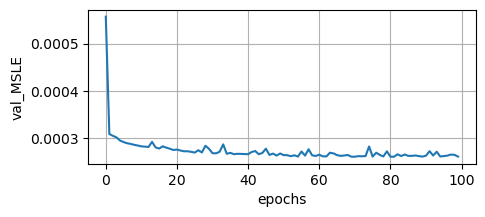

144/144 [==============================] - 0s 798us/step


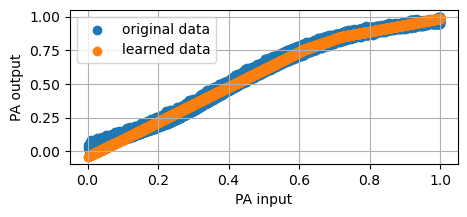

In [85]:
# TODO: plot log history
plt.figure(figsize=[5,2])
plt.plot(hist.history["val_mean_squared_logarithmic_error"])
plt.xlabel("epochs"), plt.ylabel("val_MSLE"), plt.grid()
plt.show()

# TODO: plot output
n_predict = n_timesteps*int(x.size/(n_timesteps))
x_plot = x[-n_predict:]
y_plot = y[-n_predict:]

x_predict = np.transpose(np.reshape(x_plot, (-1,1,n_timesteps)), (0,2,1))
y_pred = RNN_model.predict(x_predict)
y_plot_pred = np.transpose(np.reshape((np.transpose(y_pred, (0,2,1))), (-1,)))

plt.figure(figsize=[5,2])
plt.scatter(x_plot, y_plot, label="original data")
plt.scatter(x_predict, y_pred, label="learned data")
plt.xlabel('PA input'), plt.ylabel('PA output'), plt.legend(), plt.grid()
plt.show()



**Additional tasks**:
Try different RNN cells (SimpleRNN and LSTM) and compare their performance/complexity trade-off.
For comparison: try fitting a memoryless model (by just replacing the GRU layer) and see the difference.
You could as well try-out a time-delay NN model. This will require slight changes the input/output data configuration.

Currently our RNN operates in stateless mode, i.e. the internal state / memory of the RNN is reset after each batch. 
The mode can be changed by toggeling `stateful=True` for the RNN layer. However, this will require you to also declare the batch-size in the input layer. However, things aren't that simple unfortunately.

Additionally, the data needs to be re-arranged, since all streams in one batch are seen as parallel, independent time-series'. To ensure time continuity from one batch to another, the data needs to be arranged with (just listing the first dim here):\
`[a1, b1, c1, d1, a2, b2, c2, d2, a3, ...] where the batch size is 4 in this example, thus there are four parallel streams and the number is the batch index. Thus, a1 needs to be time-contineous with a2, in order to make the stateful-flag work. 
It is not mandatory to implement this to within this assignment - although it clearly limits the accuracy.